In [16]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

from xgboost import XGBClassifier, plot_importance

import shap 

from ipywidgets import interact_manual, fixed, widgets 

%matplotlib inline



In [18]:
project_dir = '/Users/keltim01/git_repos/TK5/Data/Big-Data-Cup-2021/'

In [20]:
womens = pd.read_csv(project_dir + 'hackathon_womens.csv')
nwhl = pd.read_csv(project_dir + 'hackathon_nwhl.csv')

In [ ]:
womens = womens.append(nwhl, ignore_index=True)

In [12]:
womens['game_id'] = womens.loc[:, ['game_date', 'Home Team', 'Away Team']].sum(axis=1).astype('category').cat.codes
womens['is_home'] = 0 
womens['is_shot'] = 0
womens['is_goal'] = 0
womens['event_id'] = womens['Event'].astype('category').cat.codes
womens['team_id'] = womens['Team'].astype('category').cat.codes
womens['player_id'] = womens['Player'].astype('category').cat.codes

for x in range(1,5):
    womens[f'Detail {x}_code'] = womens[f'Detail {x}'].astype('category').cat.codes
womens.loc[womens['Home Team'] == womens['Team'], 'is_home'] = 1
womens.loc[womens['Event']=='Shot', 'is_shot'] = 1
womens.loc[womens['Event']=='Goal', 'is_goal'] = 1
womens['goal_diff'] = womens['Home Team Goals'].sub(womens['Away Team Goals'])
womens['Clock'] = pd.to_datetime(womens['Clock'], format='%M:%S')
womens['seconds_remaining'] = womens['Clock'].dt.minute.mul(60).add(womens['Clock'].dt.second)

In [13]:
PITCH_LENGTH = 200
PITCH_WIDTH = 85 
action_id = 5
GOAL_X = PITCH_LENGTH - 10 
GOAL_Y = PITCH_WIDTH / 2

## Calculate differences in disctance for actions

In [14]:
diff_x1 = GOAL_X - womens['X Coordinate']
diff_y1 = abs(GOAL_Y - womens['Y Coordinate'])
diff_x2 = GOAL_X - womens['X Coordinate 2']
diff_y2 = abs(GOAL_Y - womens['Y Coordinate 2'])
womens['start_distance_to_goal'] = np.sqrt(diff_x1 ** 2 + diff_y1 ** 2)
womens['end_distance_to_goal'] = np.sqrt(diff_x2 ** 2 + diff_y2 ** 2)
womens['diff_x'] = womens['X Coordinate 2'] - womens['X Coordinate']
womens['diff_y'] = womens['Y Coordinate 2'] - womens['Y Coordinate']
womens['distance_covered'] = np.sqrt((womens['X Coordinate 2'] - womens['X Coordinate']) ** 2 + (womens['Y Coordinate 2'] - womens['Y Coordinate']) ** 2)

## Labels

In [15]:
goals = womens['Event'].str.contains('Goal')
y = pd.concat([womens.loc[:, 'is_goal'], womens.loc[:,'team_id']], axis = 1)
y.columns = ['goal','team_id']
for i in range(1, 10):
    for col in ['team_id', 'goal']:
        shifted = y[col].shift(-i)
        shifted[-i:] = y[col][len(y) - 1]
        y[f'{col}+{i}'] = shifted.astype(int)

scores = y['goal']
concedes = y['goal']
for i in range(1, 10):
    goal_scored = y[f'goal+{i}'] & (y[f'team_id+{i}'] == y['team_id'])
    goal_opponent = y[f'goal+{i}'] & (y[f'team_id+{i}'] != y['team_id'])
    scores = scores | goal_scored
    concedes = concedes | goal_opponent
label_scores = pd.DataFrame(scores, columns=['scores'])
label_concedes = pd.DataFrame(concedes, columns=['concedes'])    

In [17]:
df_labels = pd.concat([label_scores, label_concedes], axis=1)

## Features 

In [19]:
features = ['team_id','Period', 'Home Team Skaters', 'Away Team Skaters', 'X Coordinate',
       'Y Coordinate', 'X Coordinate 2', 'Y Coordinate 2', 'is_home', 'event_id', 'Detail 1_code', 'Detail 2_code', 'Detail 3_code', 'Detail 4_code',
       'goal_diff', 'seconds_remaining','diff_x', 'diff_y', 'distance_covered']

In [21]:
df_delays = [womens[features].shift(step).add_suffix(f'-{step}') for step in range(0,3)]
df_features = pd.concat(df_delays, axis=1)

KeyError: "['Detail 2_code', 'Detail 4_code', 'diff_x', 'is_home', 'event_id', 'team_id', 'Detail 1_code', 'distance_covered', 'goal_diff', 'diff_y', 'seconds_remaining', 'Detail 3_code'] not in index"

In [23]:
womens[['start_distance_to_goal','end_distance_to_goal','diff_x','diff_y','distance_covered']]

KeyError: "None of [Index(['start_distance_to_goal', 'end_distance_to_goal', 'diff_x', 'diff_y',\n       'distance_covered'],\n      dtype='object')] are in the [columns]"

In [1118]:
for step in range(0,3):
    df_features[f'team-{step}'] = df_features['team_id-0'] == df_features[f'team_id-{step}']

In [1119]:
df_features.columns

Index(['team_id-0', 'Period-0', 'Home Team Skaters-0', 'Away Team Skaters-0',
       'X Coordinate-0', 'Y Coordinate-0', 'X Coordinate 2-0',
       'Y Coordinate 2-0', 'is_home-0', 'event_id-0', 'Detail 1_code-0',
       'Detail 2_code-0', 'Detail 3_code-0', 'Detail 4_code-0', 'goal_diff-0',
       'seconds_remaining-0', 'diff_x-0', 'diff_y-0', 'distance_covered-0',
       'team_id-1', 'Period-1', 'Home Team Skaters-1', 'Away Team Skaters-1',
       'X Coordinate-1', 'Y Coordinate-1', 'X Coordinate 2-1',
       'Y Coordinate 2-1', 'is_home-1', 'event_id-1', 'Detail 1_code-1',
       'Detail 2_code-1', 'Detail 3_code-1', 'Detail 4_code-1', 'goal_diff-1',
       'seconds_remaining-1', 'diff_x-1', 'diff_y-1', 'distance_covered-1',
       'team_id-2', 'Period-2', 'Home Team Skaters-2', 'Away Team Skaters-2',
       'X Coordinate-2', 'Y Coordinate-2', 'X Coordinate 2-2',
       'Y Coordinate 2-2', 'is_home-2', 'event_id-2', 'Detail 1_code-2',
       'Detail 2_code-2', 'Detail 3_code-2', 'De

In [1120]:
for step in range(0,3):
    df_features.loc[~(df_features[f'team-{step}']),f'X Coordinate-{step}'] = PITCH_LENGTH - df_features[f'X Coordinate-{step}']
    df_features.loc[~(df_features[f'team-{step}']),f'X Coordinate 2-{step}'] = PITCH_LENGTH - df_features[f'X Coordinate 2-{step}']
    df_features.loc[~(df_features[f'team-{step}']),f'Y Coordinate-{step}'] = PITCH_WIDTH - df_features[f'Y Coordinate-{step}']
    df_features.loc[~(df_features[f'team-{step}']),f'Y Coordinate 2-{step}'] = PITCH_WIDTH - df_features[f'Y Coordinate 2-{step}']
    

In [1121]:
for step in range(0,3):
    start_diff_x = GOAL_X - df_features[f'X Coordinate-{step}']
    start_diff_y = abs(GOAL_Y - df_features[f'Y Coordinate-{step}'])
    df_features[f'start_distance_to_goal-{step}'] = np.sqrt(start_diff_x ** 2 + start_diff_y ** 2)
    end_diff_x = GOAL_X - df_features[f'X Coordinate 2-{step}']
    end_diff_y = abs(GOAL_Y - df_features[f'Y Coordinate 2-{step}'])
    df_features[f'end_distance_to_goal-{step}'] = np.sqrt(end_diff_x ** 2 + end_diff_y ** 2)
    df_features[f'diff_x-{step}'] = df_features[f'X Coordinate 2-{step}'] - df_features[f'X Coordinate-{step}']
    df_features[f'diff_y-{step}'] = df_features[f'Y Coordinate 2-{step}'] - df_features[f'Y Coordinate-{step}']
    df_features[f'distance_covered-{step}'] = np.sqrt((df_features[f'X Coordinate 2-{step}'] - df_features[f'X Coordinate-{step}']) ** 2 + (df_features[f'Y Coordinate 2-{step}'] - df_features[f'Y Coordinate-{step}']) ** 2)
        

In [1122]:
df_features['xdiff_sequenc_pre'] = df_features['X Coordinate-0'] - df_features['X Coordinate-2']
df_features['ydiff_sequenc_pre'] = df_features['Y Coordinate-0'] - df_features['Y Coordinate-2']
df_features['time_sequence_pre'] = df_features['seconds_remaining-0'] - df_features['seconds_remaining-2']

In [1123]:
df_features.tail(10)

,team_id-0,Period-0,Home Team Skaters-0,Away Team Skaters-0,X Coordinate-0,Y Coordinate-0,X Coordinate 2-0,Y Coordinate 2-0,is_home-0,event_id-0,...,team-2,start_distance_to_goal-0,end_distance_to_goal-0,start_distance_to_goal-1,end_distance_to_goal-1,start_distance_to_goal-2,end_distance_to_goal-2,xdiff_sequenc_pre,ydiff_sequenc_pre,time_sequence_pre
50874,1,3,4,5,4,50,NaN,NaN,1,8,...,False,186.151148,NaN,172.896645,187.561323,172.896645,NaN,-17.0,44.0,-4.0
50875,0,3,4,5,195,47,NaN,NaN,0,6,...,True,6.726812,NaN,9.604686,NaN,38.121516,16.101242,16.0,-32.0,-11.0
50876,0,3,4,5,195,47,138.0,83.0,0,5,...,False,6.726812,65.910925,6.726812,NaN,9.604686,NaN,-1.0,12.0,-7.0
50877,0,3,4,5,159,49,171.0,61.0,0,5,...,True,31.674122,26.518861,6.726812,65.910925,6.726812,NaN,-36.0,2.0,-14.0
50878,0,3,4,5,171,61,NaN,NaN,0,7,...,True,26.518861,NaN,31.674122,26.518861,6.726812,65.910925,-24.0,14.0,-14.0
50879,1,3,4,5,8,61,NaN,NaN,1,6,...,False,182.937831,NaN,162.059403,NaN,149.141711,162.059403,-33.0,25.0,-3.0
50880,1,3,4,5,8,61,29.0,82.0,1,5,...,False,182.937831,165.774697,182.937831,NaN,162.059403,NaN,-21.0,37.0,-3.0
50881,1,3,4,5,34,84,NaN,NaN,1,0,...,True,161.425679,NaN,182.937831,165.774697,182.937831,NaN,26.0,23.0,-1.0
50882,0,3,4,5,132,4,NaN,NaN,0,6,...,False,69.615013,NaN,47.940067,NaN,18.607794,43.832066,-60.0,-20.0,-3.0
50883,0,3,4,5,132,4,155.0,6.0,0,5,...,False,69.615013,50.569259,69.615013,NaN,47.940067,NaN,-34.0,3.0,-2.0


In [1124]:
df_labels.tail(10)

,scores,concedes
50874,False,False
50875,False,False
50876,False,False
50877,False,False
50878,False,False
50879,False,False
50880,False,False
50881,False,False
50882,False,False
50883,False,False


## Split Dataset

In [1125]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(
    df_features,
    df_labels,
    test_size=0.10,
    random_state=42,
    stratify=df_labels['scores'].astype(str) + '_' + df_labels['concedes'].astype(str)
)

In [1126]:
df_y_train['scores'].mean()

0.019936674309422427

In [1127]:
df_y_test['scores'].mean()

0.01984672823737473

In [1128]:
df_y_train['concedes'].mean()

0.008472540670378862

In [1129]:
df_y_test['concedes'].mean()

0.00844959717036746

In [1130]:
labels = ['scores','concedes']

In [1131]:
feat = ['start_distance_to_goal-0', 'end_distance_to_goal-0', 'start_distance_to_goal-1', 'end_distance_to_goal-1', 'start_distance_to_goal-2', 'end_distance_to_goal-2', 'team-1', 'team-2']

In [1132]:
df_X_test.columns

Index(['team_id-0', 'Period-0', 'Home Team Skaters-0', 'Away Team Skaters-0',
       'X Coordinate-0', 'Y Coordinate-0', 'X Coordinate 2-0',
       'Y Coordinate 2-0', 'is_home-0', 'event_id-0', 'Detail 1_code-0',
       'Detail 2_code-0', 'Detail 3_code-0', 'Detail 4_code-0', 'goal_diff-0',
       'seconds_remaining-0', 'diff_x-0', 'diff_y-0', 'distance_covered-0',
       'team_id-1', 'Period-1', 'Home Team Skaters-1', 'Away Team Skaters-1',
       'X Coordinate-1', 'Y Coordinate-1', 'X Coordinate 2-1',
       'Y Coordinate 2-1', 'is_home-1', 'event_id-1', 'Detail 1_code-1',
       'Detail 2_code-1', 'Detail 3_code-1', 'Detail 4_code-1', 'goal_diff-1',
       'seconds_remaining-1', 'diff_x-1', 'diff_y-1', 'distance_covered-1',
       'team_id-2', 'Period-2', 'Home Team Skaters-2', 'Away Team Skaters-2',
       'X Coordinate-2', 'Y Coordinate-2', 'X Coordinate 2-2',
       'Y Coordinate 2-2', 'is_home-2', 'event_id-2', 'Detail 1_code-2',
       'Detail 2_code-2', 'Detail 3_code-2', 'De

## Train classifiers

In [1133]:
models = {}
for label in tqdm(labels):
    model = XGBClassifier(
        n_estimators=100,
        max_depth=3
    )
    model.fit(
        X=df_X_train[feat],
        y=df_y_train[label]
    )
    models[label] = model

100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


In [1134]:
dfs_predictions = {}
for label in tqdm(labels):
    model = models[label]
    probabilities = model.predict_proba(df_X_test[feat])
    predictions = probabilities[:, 1]
    dfs_predictions[label] = pd.Series(predictions, index=df_X_test.index)
df_predictions = pd.concat(dfs_predictions, axis=1)

100%|██████████| 2/2 [00:00<00:00, 117.46it/s]


In [1135]:
df_predictions.head(10)

,scores,concedes
4332,0.022095,0.001797
1610,0.004428,0.003446
11102,0.003117,0.009455
14734,0.024936,0.007838
27369,0.002901,0.004975
12246,0.010655,0.005450
23000,0.011958,0.005212
6333,0.032937,0.002102
35258,0.027676,0.004604
41017,0.021835,0.005229


## Evaluate probabilities 
### Compute base rate probabilities 

In [1136]:
df_base_rates = pd.DataFrame({
    label:np.full(len(df_y_test[label]), df_y_train[label].mean()) for label in labels
})

In [1137]:
df_base_rates.describe()

,scores,concedes
count,5.089000e+03,5089.000000
mean,1.993667e-02,0.008473
std,3.469788e-18,0.000000
min,1.993667e-02,0.008473
25%,1.993667e-02,0.008473
50%,1.993667e-02,0.008473
75%,1.993667e-02,0.008473
max,1.993667e-02,0.008473


In [1138]:
df_predictions.describe()

,scores,concedes
count,5089.000000,5089.000000
mean,0.019808,0.008697
std,0.025659,0.018090
min,0.000159,0.000192
25%,0.006213,0.003136
50%,0.012633,0.005389
75%,0.026066,0.008918
max,0.705237,0.687127


### Compute Brier loss for goal scored model

In [1139]:
brier_score_loss(
    y_true=df_y_test['scores'],
    y_prob=df_base_rates['scores']
)

0.019452843705942396

In [1140]:
brier_score_loss(
    y_true=df_y_test['scores'],
    y_prob=dfs_predictions['scores']
)

0.01894996182102381

In [1141]:
brier_score_loss(
    y_true=df_y_test['concedes'],
    y_prob=df_base_rates['concedes']
)

0.008378202004430168

In [1142]:
brier_score_loss(
    y_true=df_y_test['concedes'],
    y_prob=dfs_predictions['concedes']
)

0.00827112486608886

## Optimization

In [1143]:
models_cv = {}
for label in tqdm(labels):
    model = GridSearchCV(
        estimator=XGBClassifier(),
        param_grid={
            'n_estimators':[50, 100],
            'max_depth': [3,4]
        },
        scoring='neg_brier_score',
        refit=True,
        verbose=10,
        n_jobs=1
    )
    model.fit(
        X=df_X_train[feat],
        y=df_y_train[label]
    )
    models_cv[label] = model

  0%|          | 0/2 [00:00<?, ?it/s]Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START max_depth=3, n_estimators=50................................
[22:45:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5; 1/4] END ..............max_depth=3, n_estimators=50; total time=   0.4s
[CV 2/5; 1/4] START max_depth=3, n_estimators=50................................
[22:45:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5; 1/4] END ..............max_depth=3, n_estimators=50; total time=   0.4s
[CV 3/5; 1/4] S

In [1144]:
dfs_predictions_cv = {}
for label in tqdm(labels):
    model = models_cv[label]
    probabilities = model.predict_proba(
        df_X_test[feat]
    )
    predictions = probabilities[:, 1]
    dfs_predictions_cv[label] = pd.Series(predictions, index=df_X_test.index)
df_predictions_cv = pd.concat(dfs_predictions, axis=1)

100%|██████████| 2/2 [00:00<00:00, 127.11it/s]


In [1145]:
brier_score_loss(
    y_true=df_y_test['scores'],
    y_prob=df_base_rates['scores']
)

0.019452843705942396

In [1146]:
brier_score_loss(
    y_true=df_y_test['scores'],
    y_prob=df_predictions_cv['scores']
)

0.01894996182102381

In [1147]:
brier_score_loss(
    y_true=df_y_test['concedes'],
    y_prob=df_base_rates['concedes']
)

0.008378202004430168

In [1148]:
brier_score_loss(
    y_true=df_y_test['concedes'],
    y_prob=df_predictions_cv['concedes']
)

0.00827112486608886

## Construct final classifiers

In [1149]:
model_scores = models_cv['scores']

In [1150]:
pd.Series(
    model_scores.best_params_
)

max_depth        3
n_estimators    50
dtype: int64

In [1151]:
pd.DataFrame(
    model_scores.cv_results_
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.396055,0.004971,0.009351,0.000712,3,50,"{'max_depth': 3, 'n_estimators': 50}",-0.019035,-0.019115,-0.019172,-0.019526,-0.019441,-0.019258,0.000191,1
1,0.807420,0.061775,0.011438,0.001190,3,100,"{'max_depth': 3, 'n_estimators': 100}",-0.019099,-0.019360,-0.019263,-0.019638,-0.019558,-0.019384,0.000195,3
2,0.583872,0.019234,0.010940,0.000664,4,50,"{'max_depth': 4, 'n_estimators': 50}",-0.019105,-0.019300,-0.019242,-0.019610,-0.019569,-0.019365,0.000194,2
3,0.992417,0.051896,0.011598,0.000688,4,100,"{'max_depth': 4, 'n_estimators': 100}",-0.019267,-0.019450,-0.019390,-0.019778,-0.019689,-0.019515,0.000190,4


In [1152]:
pd.Series(model_scores.best_estimator_.get_params())

objective                  binary:logistic
use_label_encoder                     True
base_score                             0.5
booster                             gbtree
colsample_bylevel                        1
colsample_bynode                         1
colsample_bytree                         1
gamma                                    0
gpu_id                                  -1
importance_type                       gain
interaction_constraints                   
learning_rate                          0.3
max_delta_step                           0
max_depth                                3
min_child_weight                         1
missing                                NaN
monotone_constraints                    ()
n_estimators                            50
n_jobs                                  12
num_parallel_tree                        1
random_state                             0
reg_alpha                                0
reg_lambda                               1
scale_pos_w

In [1153]:
model_scores_final = model_scores.best_estimator_

In [1154]:
model_scores_final

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [1155]:
model_scores_final2 = XGBClassifier(
    n_estimators=100,
    max_depth=4
)

In [1156]:
model_scores_final2.fit(
    X=df_X_train[feat],
    y=df_y_train[label]
)

[22:45:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

# analyze models and results 

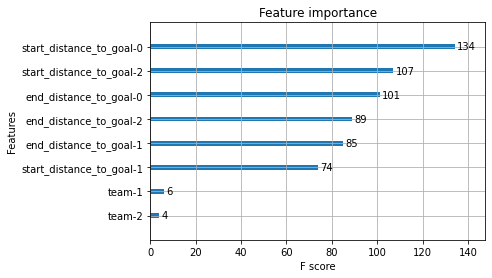

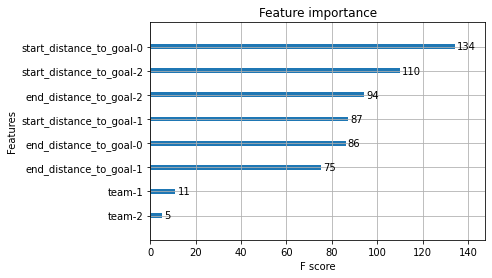

In [1157]:
for label in labels:
    plot_importance(models[label])

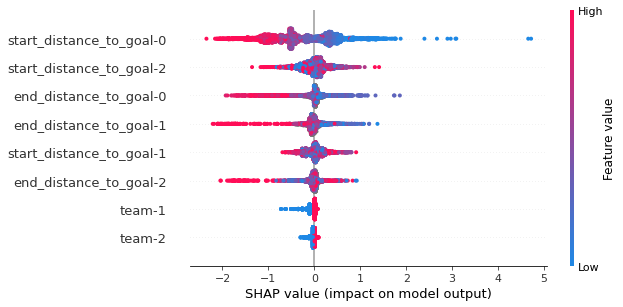

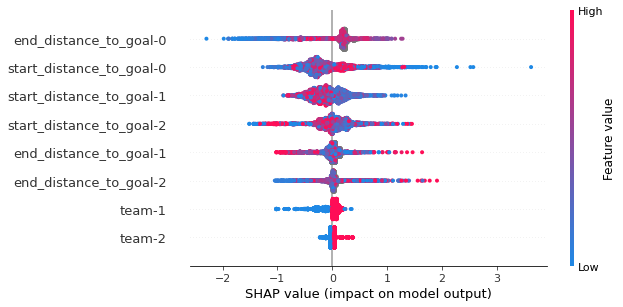

In [1158]:
for label in labels:
    explainer = shap.TreeExplainer(models[label])

    shap_values = explainer.shap_values(df_X_test[feat])
    shap.summary_plot(shap_values, df_X_test[feat])

In [1159]:
dfs_actions = []
dfs_actions.append(womens)
df_actions = pd.concat(dfs_actions).reset_index(drop=True)

In [7]:
df_actions_predictions = pd.concat([df_actions, df_predictions_cv], axis=1)

NameError: name 'df_actions' is not defined

## calculate the VAEP value


In [1161]:
dfs_values = []
df_values = pd.DataFrame()

In [1162]:
def prev(x: pd.Series) -> pd.Series:
    prev_x = x.shift(1)
    prev_x[:1] = x.values[0]
    return prev_x

In [1163]:
sameteam = prev(df_actions_predictions.team_id) == df_actions_predictions.team_id
prev_scores = prev(df_actions_predictions.scores) * sameteam + prev(df_actions_predictions.concedes) * (~sameteam)
prev_concedes = prev(df_actions_predictions.concedes) * sameteam + prev(df_actions_predictions.scores) * (~sameteam)

toolong_idx = abs(prev(df_actions_predictions.seconds_remaining) - df_actions_predictions.seconds_remaining) > 10
prev_scores[toolong_idx] = 0 
prev_concedes[toolong_idx] = 0

prevgoal_idx = prev(df_actions_predictions.Event) == 'Goal'
prev_scores[prevgoal_idx] = 0
prev_concedes[prevgoal_idx] = 0

df_values['offensive_value'] = df_actions_predictions.scores - prev_scores
df_values['defensive_value'] = df_actions_predictions.concedes - prev_concedes
df_values['vaep'] = df_values['offensive_value'] + df_values['defensive_value']
     

In [1164]:
df_values['vaep'].count()

558

In [1165]:
df_values['vaep'].value_counts(dropna=False)

 NaN         50326
-0.044163        1
-0.011049        1
 0.009094        1
-0.002029        1
             ...  
 0.002845        1
 0.004714        1
-0.106681        1
 0.001423        1
 0.390195        1
Name: vaep, Length: 559, dtype: int64

In [1166]:
df_actions_predictions['Event'].value_counts()

Puck Recovery      15174
Play               14673
Incomplete Play     6111
Zone Entry          3744
Dump In/Out         3545
Shot                3524
Takeaway            2092
Faceoff Win         1629
Penalty Taken        260
Goal                 132
Name: Event, dtype: int64

In [1167]:
df_values['vaep'].describe()

count    558.000000
mean       0.001790
std        0.043697
min       -0.258674
25%       -0.008318
50%        0.001418
75%        0.012230
max        0.605549
Name: vaep, dtype: float64